# Atari Pong Classic Reinforcement Learning

# Imports

In [1]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
from random import random, randrange, seed
from torch.nn.functional import conv2d
import torch
import os

/home/msi/miniconda3/envs/rl_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/msi/miniconda3/envs/rl_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/msi/miniconda3/envs/rl_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
seed(97120)
np.random.seed(97120)

episodes = 10000
TEST_NAME = f"no_gaussian_init_{episodes}"

In [3]:
if not os.path.exists(f"./train_history/{TEST_NAME}/"):
  os.mkdir(f"./train_history/{TEST_NAME}")

# Utils

In [4]:
def normalize(data):
  data = data - data.mean()
  data = data / data.std()
  return data

In [5]:
def preprocessing(obs):
    # clipping and resizing the observation of the screen
    obs = obs[35:192:3, ::2, :]
    return obs

In [6]:
def get_actions_from_env(env):
    actions = env.action_space.n
    return list(range(0, actions))

In [7]:
def plot_qtable(q_table, action=3, save=False):
  q_table = q_table[:-1, : , :]
  q_table = q_table.reshape(53, 80, 54, 6)
  #q_table = normalize(q_table)
  
  fig, axs = plt.subplots(3, 6, figsize=(12, 5))
  fig.suptitle(f'Action {action} (position racket)')

  for idx, i in enumerate(range(0,54,3)):  
    axs[idx//6, idx%6].imshow(q_table[:,:,i,action], vmin=-1, vmax=1, cmap="gray")
    axs[idx//6, idx%6].set_title(f"{i}")
  
  if save:
    plt.savefig(f"./train_history/{TEST_NAME}/{TEST_NAME}_QT_A{action}")
    
  plt.show()

# Policies

In [8]:
def exploration_policy() -> int:
    return randrange(3) + 1

In [9]:
def greedy_policy(actions):
    actions = actions[:4]
    return np.where(actions == actions.max())[0][0].item()

In [10]:
def e_greedy_policy(actions, e=0.9):
    actions = actions[:4]
    
    return (
        np.random.randint(0, actions.shape[0], (1,))[0]
        if random() < (1 - e)
        else np.where(actions == actions.max())[0][0]
    )

# Qlearning

In [11]:
class QLearning:
    def __init__(self, qtable_file: str = None):
        self.setup(qtable_file)              

        self.state = 0
        self.action = 0
        self.reward = 0
        self.update_past(np.zeros((53 + 1, 80 + 1, 3)), 0, 0)        

    def setup(self, qtable_file: str = None):
        self.qtable = 0

        if qtable_file is None:
            self.qtable = np.random.rand(53 * 80 + 1, 53 + 1, 6).astype(np.float32)/10
        else:
            self.qtable = np.array(np.load(qtable_file))

        self.qtable = self.qtable[0] if type(self.qtable) is tuple else  self.qtable
       

    def step(self, state_next, reward, alpha=0.3, gamma=0.9):

        # states to coordinates
        ball, green = self.get_entities_positions(self.state)
        ball_next, green_next = self.get_entities_positions(state_next)
        action_next = greedy_policy(self.get_actions_by_obs(state_next))

        # gaussian qlearning
        self.qtable[ball, green, self.action] += alpha * (
            self.reward
            + gamma
            * self.qtable[ball_next, green_next, action_next]
            - self.qtable[ball, green, self.action]
        )

        self.update_past(state_next, action_next, reward)

    def update_past(self, state, action, reward):
        self.state = state
        self.action = action
        self.reward = reward

    def get_entities_positions(self, obs):
        """
        Given an observation the function returns the pixel coordinates
        of the rackets and the ball.

        NB:The coordinate of each entity (ball, racket_0, racket_1) are choosen
        as the last pixel from left to right and the last from top to bottom.
        """
        # segmenting the agents and the ball
        ball_obs = np.expand_dims((obs[:, :, 2] > 200) * 1, 2)

        green_player_obs = np.expand_dims((obs[:, :, 1] > 180) * 1, 2)
        green_player_obs = green_player_obs - ball_obs

        # retrieving agents and ball position
        ball_obs = ball_obs.reshape(-1)
        ball_pos = np.max(ball_obs * np.arange(ball_obs.shape[0]))

        green_player_obs = green_player_obs.reshape(-1)
        green_pos = np.max(green_player_obs * np.arange(green_player_obs.shape[0]))

        return (
            int(ball_pos.item()),
            int(self.racket_pos_to_coordinates(green_pos).item()),
        )

    def racket_pos_to_coordinates(self, pos):
        return np.floor(pos / 80) + (1 if pos.item() % 80 != 0 else 0)

    def get_actions_by_obs(self, state):
        ball, green = self.get_entities_positions(state)
        return self.qtable[ball, green, :]

    def save_qtables(self, name):
        np.save(name, self.qtable)

# Training

In [12]:
q_learn = QLearning()
env = gym.make("ALE/Pong-v5")
history = []

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


In [13]:

for episode in range(episodes):
    print(f"Episode {episode}")
    cumulative_reward = 0

    obs, info = env.reset(seed=97120)
    obs = preprocessing(obs)

    for c in range(1000):
        #action = env.action_space.sample()
        action = e_greedy_policy(q_learn.get_actions_by_obs(obs))

        obs, reward, term, trunc, info = env.step(action)
        obs = preprocessing(obs)  # cleaning useless pixels from obs

        #reward -= 0.001

        # qlearning
        q_learn.step(obs, reward)

        # game leaderboard
        cumulative_reward += reward

        if abs(reward) > 0.5 and False:
            print(f"action {action}, reward {reward} ({cumulative_reward})")
            plot_qtable(np.clip(q_learn.qtable, -10, 10))

    history.append(cumulative_reward)
    print(f"{'CONCLUSO' if term else 'TRONCATO'} => {cumulative_reward}")

env.close()
q_learn.save_qtables(f"./train_history/{TEST_NAME}/{TEST_NAME}")

Episode 0
CONCLUSO => -21.0
Episode 1
CONCLUSO => -20.0
Episode 2
TRONCATO => -17.0
Episode 3
CONCLUSO => -20.0
Episode 4
CONCLUSO => -21.0
Episode 5
TRONCATO => -18.0
Episode 6
CONCLUSO => -20.0
Episode 7
CONCLUSO => -21.0
Episode 8
CONCLUSO => -21.0
Episode 9
CONCLUSO => -21.0
Episode 10
TRONCATO => -16.0
Episode 11
CONCLUSO => -20.0
Episode 12
CONCLUSO => -21.0
Episode 13
CONCLUSO => -21.0
Episode 14
TRONCATO => -14.0
Episode 15
CONCLUSO => -21.0
Episode 16
CONCLUSO => -21.0
Episode 17
CONCLUSO => -21.0
Episode 18
CONCLUSO => -21.0
Episode 19
CONCLUSO => -21.0
Episode 20
CONCLUSO => -21.0
Episode 21
CONCLUSO => -21.0
Episode 22
CONCLUSO => -21.0
Episode 23
CONCLUSO => -20.0
Episode 24
CONCLUSO => -21.0
Episode 25
CONCLUSO => -21.0
Episode 26
CONCLUSO => -21.0
Episode 27
CONCLUSO => -21.0
Episode 28
CONCLUSO => -20.0
Episode 29
CONCLUSO => -21.0
Episode 30
CONCLUSO => -21.0
Episode 31
TRONCATO => -14.0
Episode 32
CONCLUSO => -21.0
Episode 33
CONCLUSO => -21.0
Episode 34
CONCLUSO => -

# Plotting

## Cumulative reward

In [14]:
history = np.array(history)

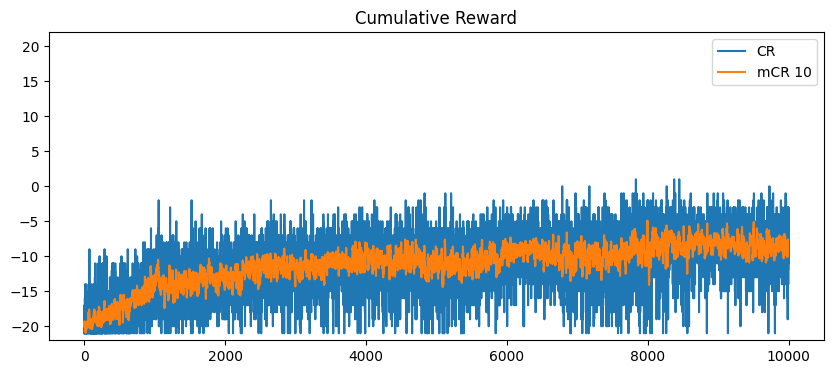

In [15]:
mean_window = 10
mean_cr = np.zeros(history.shape[0] - mean_window)
for idx in range(history.shape[0] - mean_window):
    mean_cr[idx] = history[idx:idx + mean_window].mean()

np.save(f"./train_history/{TEST_NAME}/{TEST_NAME}_history", history)
    
plt.figure(figsize=(10, 4))
plt.title("Cumulative Reward")
plt.plot(history, label="CR")
plt.plot(mean_cr, label="mCR 10")
plt.legend(loc="upper right")
plt.ylim([-22, 22])
plt.savefig(f"./train_history/{TEST_NAME}/{TEST_NAME}_CR")
plt.show()

## Qtable 

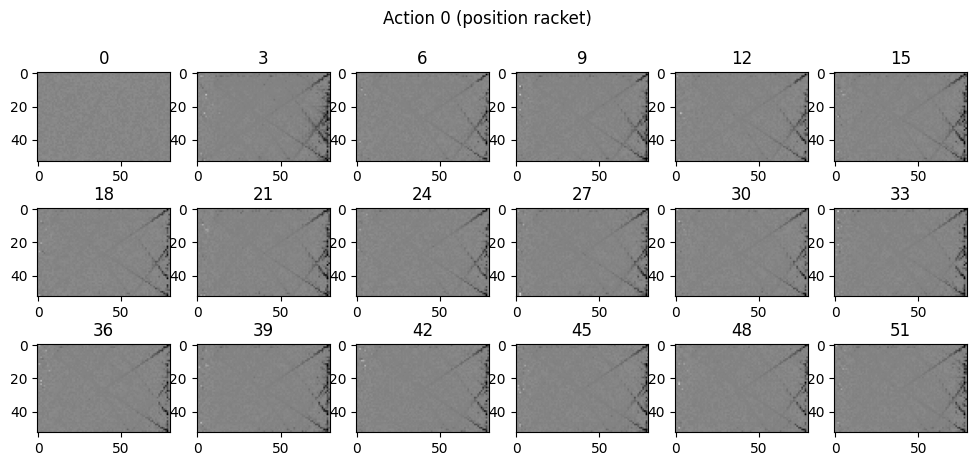

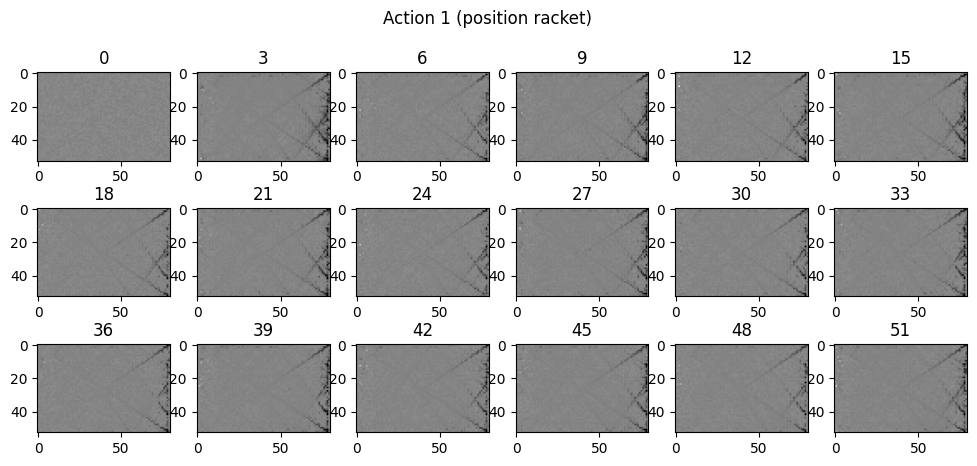

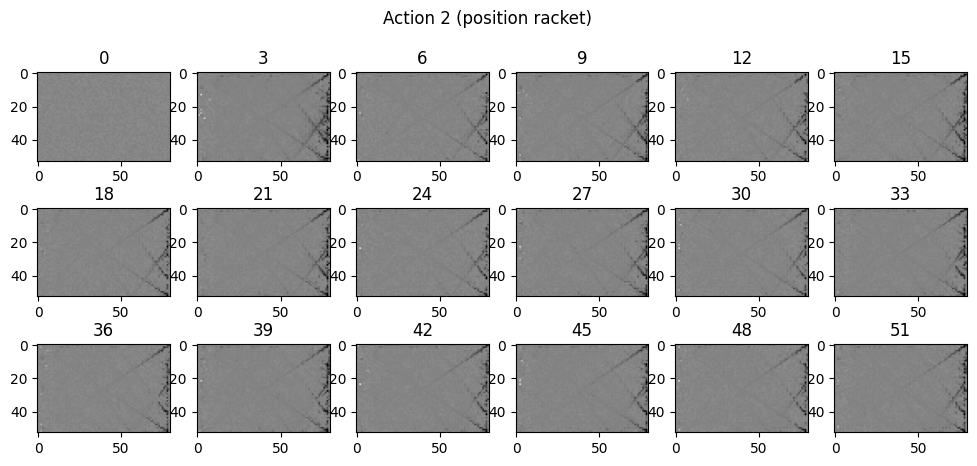

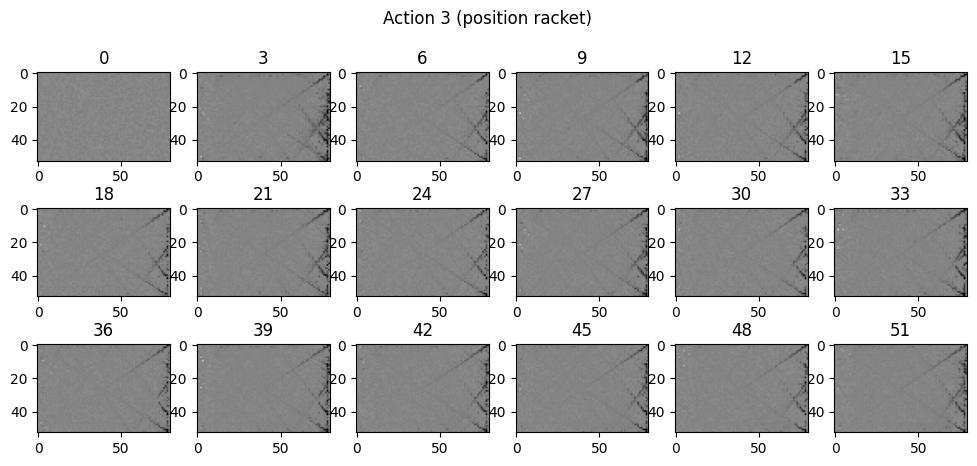

In [16]:
for action in range(4):
  plot_qtable(q_learn.qtable, action, save=True)

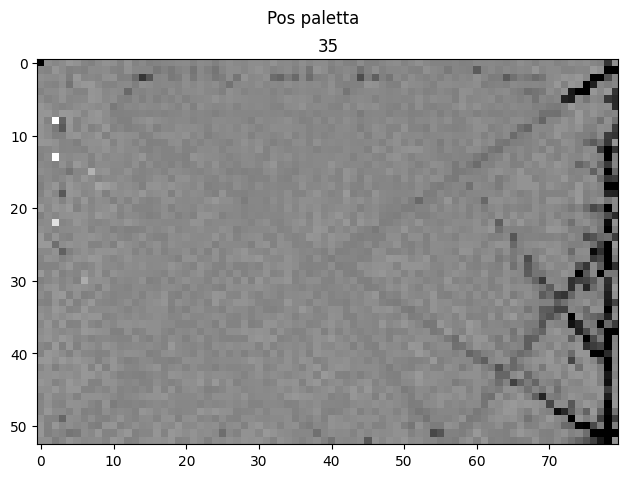

In [17]:
q_table = q_learn.qtable
q_table = q_table[:-1, : , :]
q_table = q_table.reshape(53, 80, 54, 6)

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
fig.suptitle('Pos paletta')

axs.imshow(q_table[:,:,9,0], vmin=-0.5, vmax=0.5, cmap="gray")
axs.set_title(f"35")

plt.show()